In [1]:
import sys
import os
import time
import datetime
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
import seaborn as sn
from scipy import stats

from keras import backend as K
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

path_main_folder = '/home/antorosi/Documents/AutoEncoder'
path_sub_folder = '/home/antorosi/Documents/Prediction'

sys.path.append(path_main_folder)

from CVAE.cvae import compile_cvae, run_cvae
from CVAE.cvae_model import CVAE
from conso.load_shape_data import *  
from conso.conso_helpers import *

/local/home/antorosi/PycharmProjects/KERAS-TS-VENV/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Load and shape data

In [2]:
# Load raw data
path_data = os.path.join(path_main_folder, 'data')
dict_data_conso = load_data_conso(path_data)

In [3]:
# Load Holiday day information
holiday_days_csv = os.path.join(path_data, "joursFeries.csv")
holiday_days_df = pd.read_csv(holiday_days_csv, sep=";")
holiday_days_df.ds = pd.to_datetime(holiday_days_df.ds)
holiday_days_df['is_hd'] = 1

In [4]:
# Unifomization
data_conso_df, dict_colnames_conso = get_uniformed_data_conso(dict_data_conso)

In [5]:
# Change ganularity ?
name_granu = '30m'
data_conso_df = change_granularity(data_conso_df, granularity="30min")

In [6]:
# Get x_conso dataframe for autoencoder purpose
x_conso = get_x_conso_autoencoder(data_conso_df, dict_colnames_conso)

In [7]:
# Split train and test
dict_xconso = {'train': x_conso}

In [8]:
# Normalize x_conso
type_scaler = 's'
dict_xconso = normalize_xconso(dict_xconso, dict_colnames_conso, type_scaler = 'standard')

name_type_cond = 'm-wd'
name_train = '0' # 1: first period ; 0 all periods
name_type_x = 'c-temp'
type_x = ['conso', 'temperature']
type_cond = ['month', 'weekday']

dataset = get_dataset_autoencoder(dict_xconso=dict_xconso, type_x=type_x, type_cond=type_cond)

### Model parameters

In [9]:
# model paths
path_model_folder = os.path.join(path_main_folder, 'out', 'cvae_conso_e48-24-12_d12-24-48_gran-30m_x-c-temp_cond-m-wd')
name_dict_dataset = 'dict_datasets.pickle'
name_model = 'CVAE'

In [10]:
cond_dim = dataset['train']['x'][1].shape[1]
e_dims=[48,24,12]
d_dims=[12,24,48]
z_dim= 2
beta = 0.6

### Load model

In [11]:
model = CVAE(cond_dim=cond_dim, e_dims=e_dims, d_dims=d_dims, 
             z_dim=z_dim, beta=beta, name=name_model, output=path_model_folder, verbose=False)
model.load_model(os.path.join(path_model_folder,'models'))

### Generation 

##### Latent space projection

In [12]:
name_set_plot = 'train'

In [13]:
x_encoded = model.encoder.predict(dataset[name_set_plot]['x'])[0]

In [14]:
calendar_info = pd.DataFrame(dataset[name_set_plot]['ds'])
calendar_info['month'] = calendar_info.ds.dt.month
calendar_info['weekday'] = calendar_info.ds.dt.weekday
calendar_info['is_weekday'] = (calendar_info.weekday < 5).apply(lambda x:int(x))
calendar_info = pd.merge(calendar_info, holiday_days_df[['ds', 'is_hd']], on='ds', how ='left')
calendar_info.loc[calendar_info['is_hd'].isna(),'is_hd'] = 0


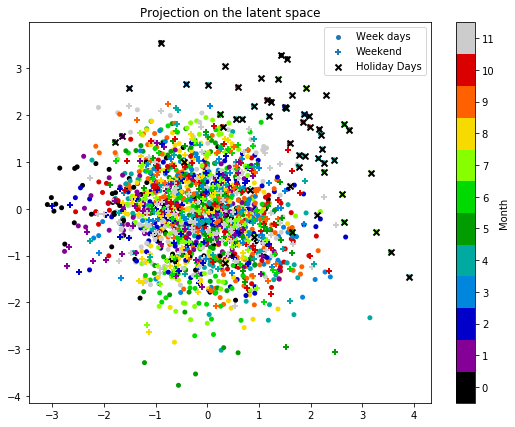

In [16]:
pyplot_latent_space_projection(x_proj=x_encoded, calendar_info=calendar_info,
                             path_folder_out=None, name=None, size_fig=(9,7))

##### Generation 

In [82]:
def get_one_hot_cond(cond_compact):

    cond = np.zeros((14), dtype='int')
    cond[cond_compact[0]-1] = 1
    cond[12+cond_compact[1]] = 1
    
    cond = cond.reshape(1,-1)
        
    return cond

In [103]:
cond_compact = [8,1] # month, weekday or not
z = np.array([0,0]).reshape(1,-1) # projection on the latent space

In [104]:
cond = get_one_hot_cond(cond_compact)

In [105]:
x_generated = model.decoder.predict([z, cond])

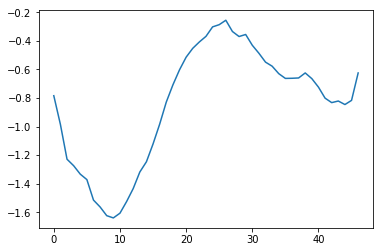

In [106]:
plt.plot(x_generated[0,:47])
plt.show()

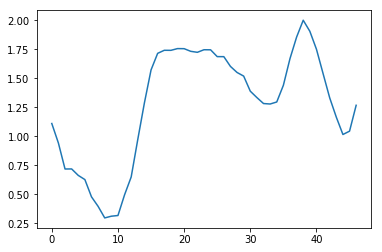

In [98]:
plt.plot(x_generated[0,:47])
plt.show()